## Web Crawing
- 웹 페이지에서 데이터를 수집하는 방법에 대해서 학습

### 웹크롤링 방법

#### 웹페이지의 종류
- 정적인 페이지 : 웹 브라우져에 화면이 한번 뜨면 이벤트에 의한 화면의 변경이 없는 페이지 
- 동적인 페이지 : 웹 브라우져에 화면이 뜨고 이벤트가 발생하면 서버에서 데이터를 가져와 화면을 변경하는 페이지

#### requests 이용
- 받아오는 문자열에 따라 두가지 방법으로 구분
    - json 문자열로 받아서 파싱하는 방법 : 주로 동적 페이지 크롤링할때 사용 
    - html 문자열로 받아서 파싱하는 방법 : 주로 정적 페이지 크롤링할때 사용
        
#### selenium 이용
- 브라우져를 직접 열어서 데이터를 받는 방법

#### 크롤링 방법에 따른 속도
- requests json > requests html > selenium

### Crwaling Naver Stock Datas
- 네이버 증권 사이트에서 주가 데이터 수집
- 수집할 데이터 : 일별 kospi, kosdaq 주가, 일별 환율(exchange rate) 데이터
- 데이터 수집 절차
    - 웹서비스 분석 : url
    - 서버에 데이터 요청 : request(url) > response : json(str)
    - 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import requests

In [4]:
# 1. 웹페이지분석 : 크롬개발자도구 : URL
# 2. request(URL) > response(DATA) : DATA(json(str))
# 3. DATA(json(str)) > list, dict > DataFrame

#### 1. 웹서비스 분석 : url
- pc 웹페이지가 복잡하면 mobile 웹페이지에서 수집

In [8]:
page, pagesize = 1, 20
url = f'https://m.stock.naver.com/api/index/KOSPI/price?pageSize={pagesize}&page={page}'
print(url)

https://m.stock.naver.com/api/index/KOSPI/price?pageSize=20&page=1


#### 2. 서버에 데이터 요청 : request(url) > response : json(str)
- response의 status code가 200이 나오는지 확인
- 403이나 500이 나오면 request가 잘못되거나 web server에서 수집이 안되도록 설정이 된것임
    - header 설정 또는 selenium 사용
- 200이 나오더라도 response 안에 있는 내용을 확인 > 확인하는 방법 : response.text

In [13]:
response = requests.get(url)
response, response.text[:200]

(<Response [200]>,
 '[{"localTradedAt":"2023-09-04","closePrice":"2,579.34","compareToPreviousClosePrice":"15.63","compareToPreviousPrice":{"code":"2","text":"상승","name":"RISING"},"fluctuationsRatio":"0.61","openPrice":"2')

#### 3. 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [19]:
type(response.text), type(response.json())

(str, list)

In [22]:
data = response.json()
kospi = pd.DataFrame(data)[['localTradedAt', 'closePrice']]
kospi.tail(2)

,localTradedAt,closePrice
18,2023-08-08,"2,573.98"
19,2023-08-07,"2,580.71"


#### 4. 함수로 만들기

In [26]:
def stock_crawling(code='KOSPI', page=1, pagesize=60):
    
    # 1. 웹페이지분석 : 크롬개발자도구 : URL
    url = f'https://m.stock.naver.com/api/index/{code}/price?pageSize={pagesize}&page={page}'
    
    # 2. request(URL) > response(DATA) : DATA(json(str))
    response = requests.get(url)
    
    # 3. DATA(json(str)) > list, dict > DataFrame
    return pd.DataFrame(response.json())[['localTradedAt', 'closePrice']]

In [27]:
kospi = stock_crawling()
kosdaq = stock_crawling('KOSDAQ')
kosdaq.tail(2)

,localTradedAt,closePrice
58,2023-06-13,896.81
59,2023-06-12,885.76


#### 5. 원달러 환율 데이터 수집 : 실습

In [36]:
# 1. 웹페이지분석 : 크롬개발자도구 : URL
page, pagesize = 1, 60
url = f'https://m.stock.naver.com/front-api/v1/marketIndex/prices?\
page={page}&category=exchange&reutersCode=FX_USDKRW&pageSize={pagesize}'

# 2. request(URL) > response(DATA) : DATA(json(str))
response = requests.get(url)

# 3. DATA(json(str)) > list, dict > DataFrame
usd = pd.DataFrame(response.json()['result'])[['localTradedAt', 'closePrice']]
usd.tail(2)

,localTradedAt,closePrice
58,2023-06-13,"1,272.00"
59,2023-06-12,"1,290.00"


#### 6. 시각화

In [37]:
# 데이터분석
# 계획수립(문제정의) > 데이터수집(web_crawling) > 데이터전처리(pandas)
# > 데이터분석(pandas,sklearn) > 레포팅,피드백(matplotlib)

In [39]:
len(kospi), len(kosdaq), len(usd)

(60, 60, 60)

In [60]:
# 데이터전처리 1 : 컬럼 : 날짜, 코스피, 코스닥, 환율
df = kospi.copy() # 얕은복사, 깊은복사
df.columns = ['date', 'kospi']
df['kosdaq'] = kosdaq['closePrice']
df['usd'] = usd['closePrice']
df.tail(2)

,date,kospi,kosdaq,usd
58,2023-06-13,"2,637.95",896.81,"1,272.00"
59,2023-06-12,"2,629.35",885.76,"1,290.00"


In [61]:
# 데이터전처리 2 : 데이터타입변경
df['kospi'] = df['kospi'].apply(lambda data: data.replace(',', '')).astype('float')
df['kosdaq'] = df['kosdaq'].apply(lambda data: data.replace(',', '')).astype('float')
df['usd'] = df['usd'].apply(lambda data: data.replace(',', '')).astype('float')
df.dtypes

date       object
kospi     float64
kosdaq    float64
usd       float64
dtype: object

In [64]:
%config InlineBackend.figure_formats = {'png', 'retina'}

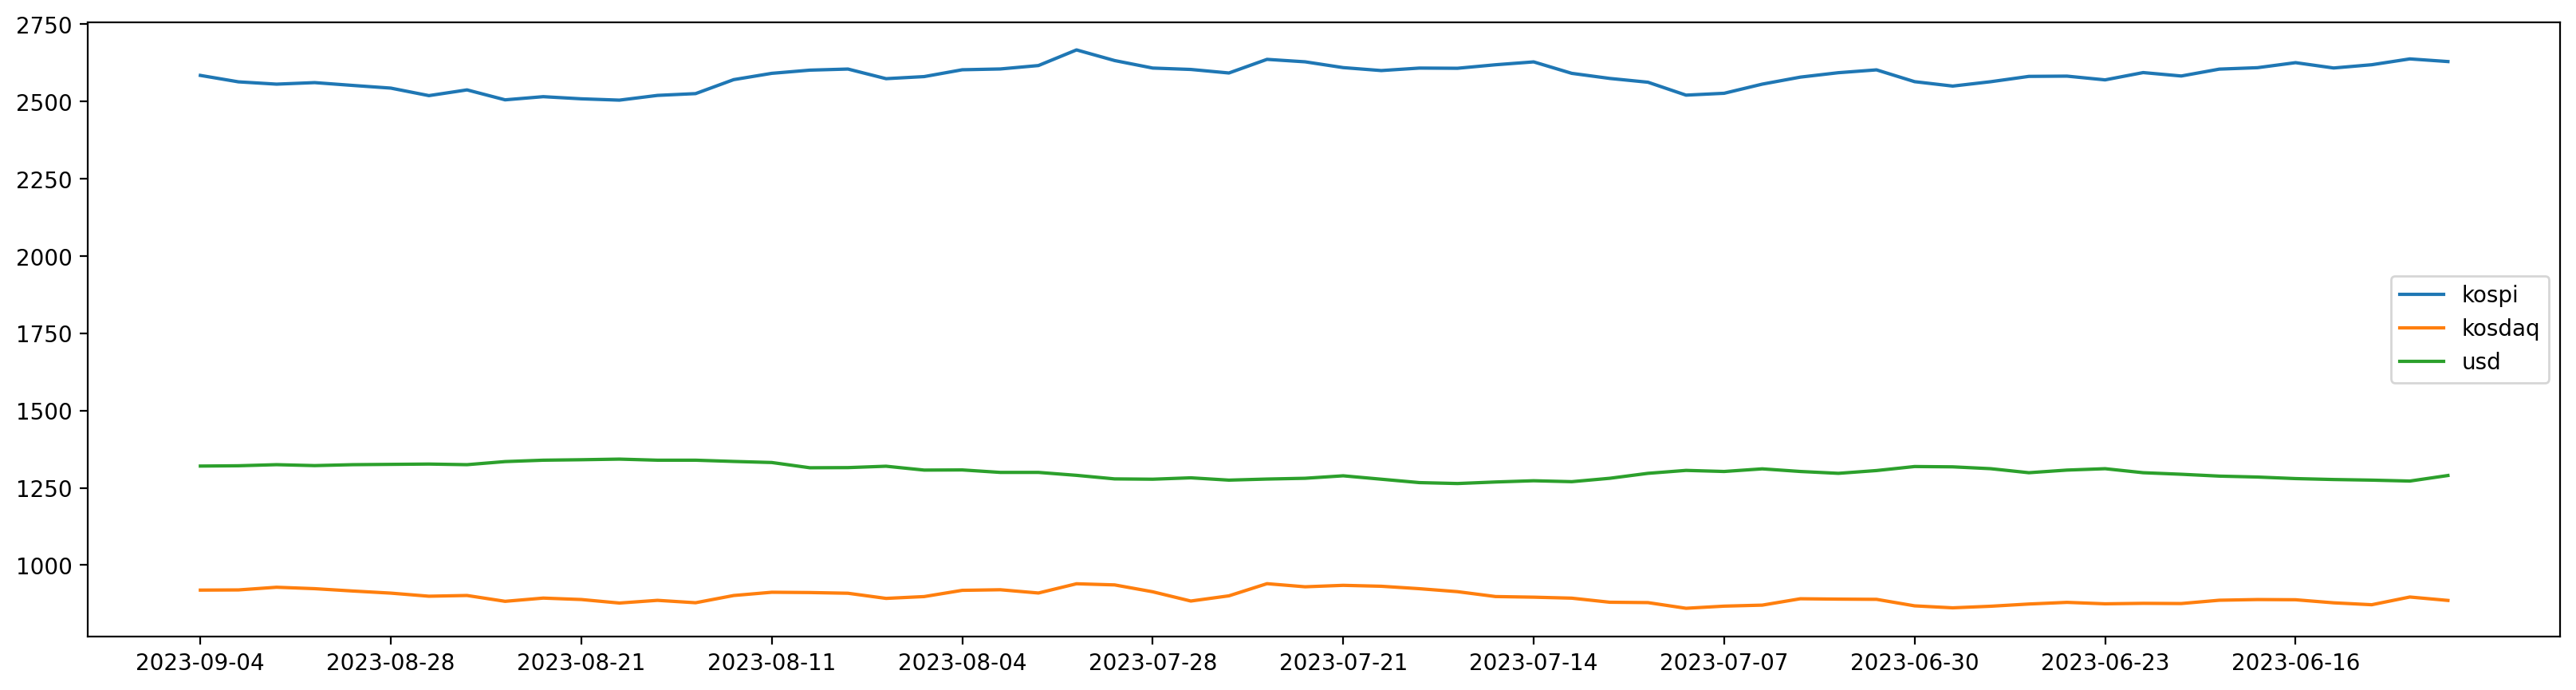

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(df['date'], df['kospi'], label='kospi')
plt.plot(df['date'], df['kosdaq'], label='kosdaq')
plt.plot(df['date'], df['usd'], label='usd')
plt.xticks(df['date'].values[::5])
plt.legend()
plt.show()

#### 7. 데이터 스케일링
- min max scaling


- $z = \frac{x_i - min(x)}{max(x) - min(x)} (0 \leqq z \leqq 1)$


- latex syntax : `https://jjycjnmath.tistory.com/117`

In [71]:
from sklearn.preprocessing import minmax_scale
minmax_scale(df['kospi'])

array([0.49240327, 0.36421234, 0.31844744, 0.34889586, 0.29316602,
       0.23934305, 0.09005352, 0.2040967 , 0.0061512 , 0.06913945,
       0.02645014, 0.        , 0.09442086, 0.13003629, 0.40825491,
       0.5336778 , 0.59703512, 0.61893338, 0.42738513, 0.46878268,
       0.60466261, 0.62059421, 0.68874946, 1.        , 0.78784524,
       0.63861721, 0.61087532, 0.54044412, 0.81171188, 0.76293289,
       0.64747493, 0.58885403, 0.63812512, 0.63431137, 0.70431199,
       0.76151812, 0.53349326, 0.43193701, 0.35670788, 0.09964938,
       0.13661807, 0.31857046, 0.45826413, 0.54628775, 0.60263271,
       0.36771852, 0.28000246, 0.36716491, 0.47296549, 0.47794796,
       0.40351848, 0.54868672, 0.48059298, 0.61764163, 0.64587562,
       0.74607861, 0.63997047, 0.70480408, 0.82087716, 0.76797687])

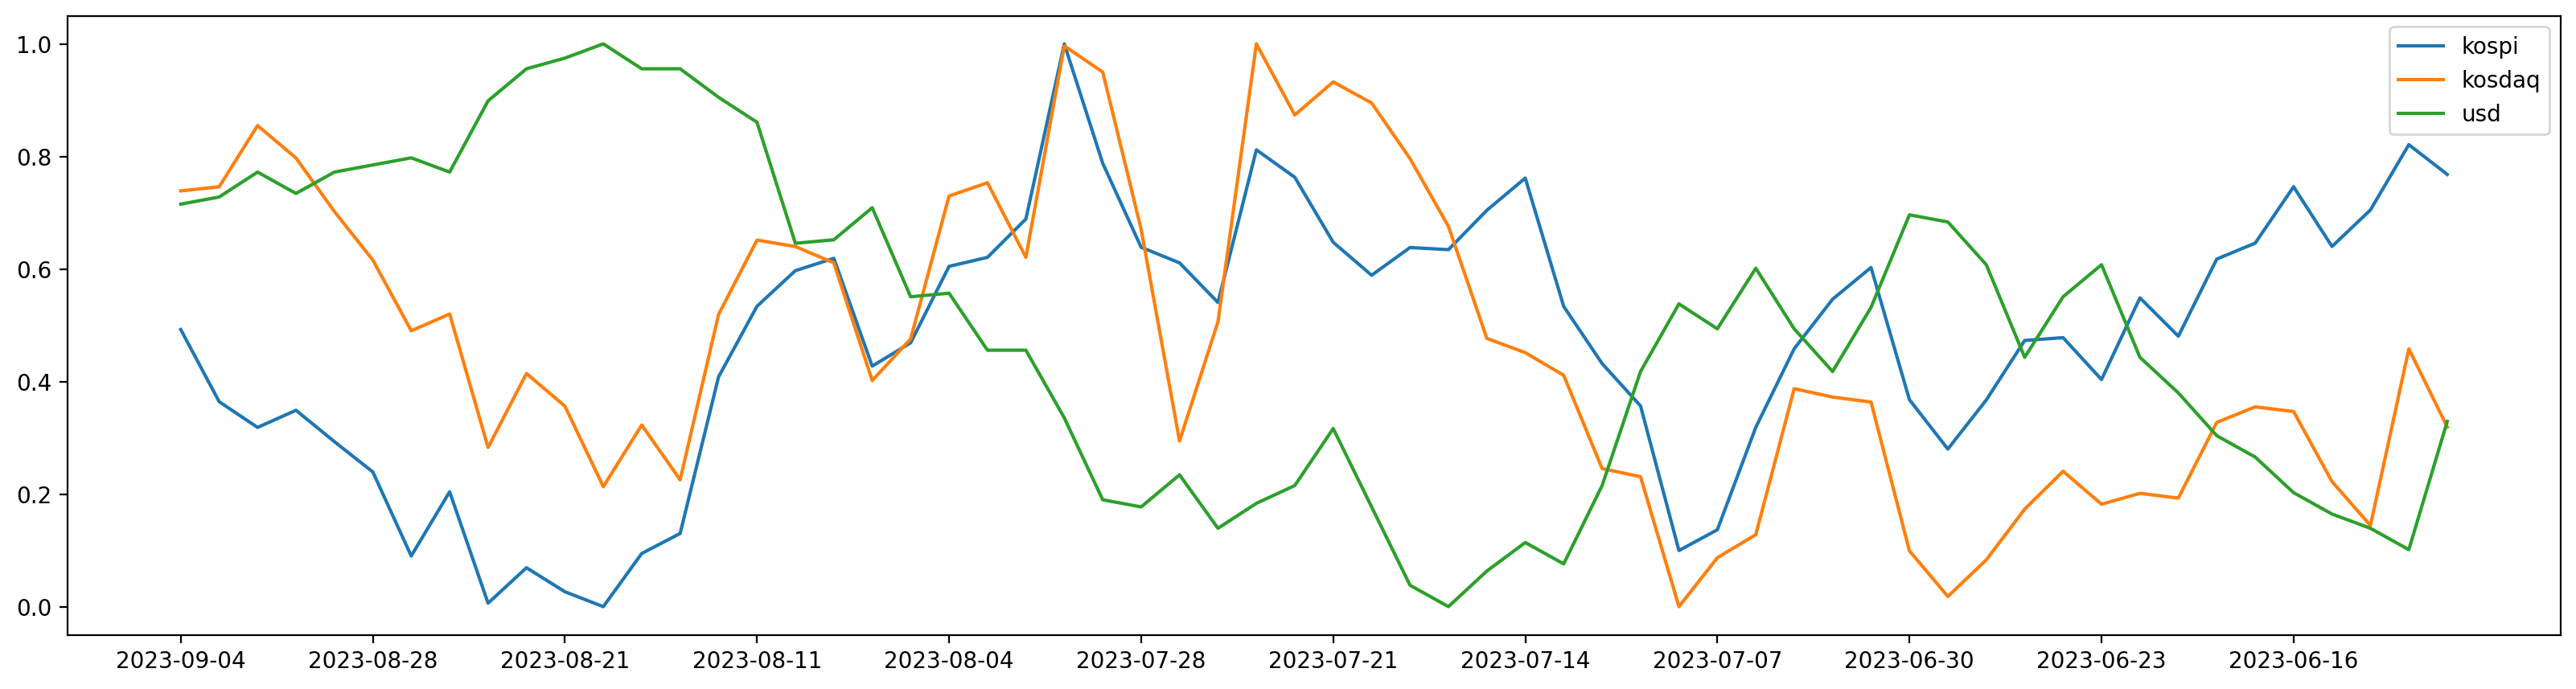

In [72]:
plt.figure(figsize=(20, 5))
plt.plot(df['date'], minmax_scale(df['kospi']), label='kospi')
plt.plot(df['date'], minmax_scale(df['kosdaq']), label='kosdaq')
plt.plot(df['date'], minmax_scale(df['usd']), label='usd')
plt.xticks(df['date'].values[::5])
plt.legend()
plt.show()

#### 8. 상관관계 분석
- 피어슨 상관계수(Pearson Correlation Coefficient)
- 두 데이터 집합의 상관도를 분석할때 사용되는 지표
- 상관계수의 해석
    - -1에 가까울수록 서로 반대방향으로 움직임
    - 1에 가까울수록 서로 같은방향으로 움직임
    - 0에 가까울수록 두 데이터는 관계가 없음

In [76]:
# 문제정의 : 원달러환율과 코스피주가는 반대방향으로 움직인다.
# > 원달러환율이 낮으면 > 환전(원>달러) : 원달러환율이 높으면 > 환전(달러>원) > 코스피 구매

In [77]:
df.corr()

,kospi,kosdaq,usd
kospi,1.000000,0.435544,-0.777496
kosdaq,0.435544,1.000000,-0.163426
usd,-0.777496,-0.163426,1.000000


### finance data reader package
- yahoo finance api를 사용한 주가 데이터 수집을 위한 package
- `https://financedata.github.io/posts/finance-data-reader-users-guide.html`

In [83]:
# !pip install -U finance-datareader

In [80]:
import FinanceDataReader as fdr

In [81]:
usd = fdr.DataReader('USD/KRW', '2020')
kospi = fdr.DataReader('KS11', '2020')
kospi.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-01,2551.929932,2568.419922,2551.040039,2563.709961,2563.709961,492400
2023-09-04,2566.929932,2584.550049,2560.320068,2584.550049,2584.550049,337309


In [84]:
usd.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-01,1324.640015,1324.640015,1311.300049,1324.640015,1324.640015,0
2023-09-04,1317.530029,1321.770020,1315.569946,1318.630005,1318.630005,0


In [ ]:
# 웹크롤링
# 서버 클라이언트 구조 : URL 구조 : request(url) > response(data(json)) : data(json) > DataFrame
# response 데이터 수집시 : json(동적), html(정적)

# 웹크롤링 프로세스
# 1. 개발자도구 : 웹페이지분석 : url
# 2. request(url) > response(data) : data(json)
# 3. data(json) > list, dict > DataFrame